# Load and preview the dataset

In [27]:
import pandas as pd

In [28]:
# Load data
df = pd.read_csv("incendies_meteo_safe.csv", delimiter=';')

# Basic overview
print(f"Dataset shape: {df.shape}")
print("Columns and data types:")
print(df.dtypes)

# Show first few rows
df.head()


Dataset shape: (29731, 34)
Columns and data types:
Année                                           int64
Numéro                                          int64
Département                                    object
Code INSEE                                     object
Nom de la commune                              object
Date de première alerte                        object
Surface parcourue (m2)                          int64
Surface forêt (m2)                            float64
Surface maquis garrigues (m2)                 float64
Autres surfaces naturelles hors forêt (m2)    float64
Surfaces agricoles (m2)                       float64
Autres surfaces (m2)                          float64
Surface autres terres boisées (m2)            float64
Surfaces non boisées naturelles (m2)          float64
Surfaces non boisées artificialisées (m2)     float64
Surfaces non boisées (m2)                     float64
Précision des surfaces                         object
Type de peuplement             

C:\Users\Antoine Dupont\AppData\Local\Temp\ipykernel_19084\881325847.py:2: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("incendies_meteo_safe.csv", delimiter=';')


,Année,Numéro,Département,Code INSEE,Nom de la commune,Date de première alerte,Surface parcourue (m2),Surface forêt (m2),Surface maquis garrigues (m2),Autres surfaces naturelles hors forêt (m2),...,latitude,longitude,temp,humidity,pressure,wind_speed,wind_deg,clouds,rain_1h,weather
0,2014,6330,66,66190,Salses-le-Château,2014-01-02 14:56:00,10000,NaN,10000.0,NaN,...,42.508676,3.074069,13.9,69.0,1013.3,7.6,140.0,NaN,NaN,NaN
1,2014,2369,06,06074,Lantosque,2014-01-07 13:50:00,48400,NaN,48400.0,NaN,...,43.079398,2.175422,11.9,95.0,1019.3,24.1,90.0,NaN,NaN,NaN
2,2014,2546,2A,2A139,Lecci,2014-01-09 16:14:00,10,NaN,NaN,NaN,...,46.233730,5.353878,11.4,71.0,1017.6,14.8,180.0,NaN,0.0,NaN
3,2014,6,65,65173,Esterre,2014-01-10 20:04:00,10000,10000.0,NaN,0.0,...,46.233730,5.353878,3.9,95.0,1019.3,0.0,NaN,NaN,NaN,NaN
4,2014,8243,2B,2B058,Canari,2014-01-11 14:00:00,100,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The dataset has 29,731 rows and 34 columns.

# Cleaning and preprocessing

In [29]:
# Convert date column to datetime
df['Date de première alerte'] = pd.to_datetime(df['Date de première alerte'], errors='coerce')

# Investigate column 19 - "Décès ou bâtiments touchés"
print("Unique values in 'Décès ou bâtiments touchés':")
print(df['Décès ou bâtiments touchés'].unique())

# Convert columns that should be numeric but might have issues
numeric_cols = [
    'temp', 'humidity', 'pressure', 'wind_speed', 'wind_deg', 'clouds', 'rain_1h',
    'Surface parcourue (m2)', 'Surface forêt (m2)', 'Surface maquis garrigues (m2)',
    'Autres surfaces naturelles hors forêt (m2)', 'Surfaces agricoles (m2)',
    'Autres surfaces (m2)', 'Surface autres terres boisées (m2)',
    'Surfaces non boisées naturelles (m2)', 'Surfaces non boisées artificialisées (m2)',
    'Surfaces non boisées (m2)', 'Nombre de décès', 'Nombre de bâtiments totalement détruits',
    'Nombre de bâtiments partiellement détruits', 'Type de peuplement'
]

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Summary of missing data percentage by column
missing_pct = df.isnull().mean() * 100
print("\nPercentage of missing data per column (descending):")
print(missing_pct.sort_values(ascending=False))

# Show info again after conversion
df.info()


Unique values in 'Décès ou bâtiments touchés':
[nan 'Non' 'Oui']

Percentage of missing data per column (descending):
weather                                       100.000000
clouds                                        100.000000
Précision de la donnée                         97.265480
Nombre de bâtiments partiellement détruits     97.087215
Nombre de décès                                97.087215
Nombre de bâtiments totalement détruits        97.083852
Autres surfaces (m2)                           86.387945
Surfaces agricoles (m2)                        86.334129
Décès ou bâtiments touchés                     84.090680
Surfaces non boisées artificialisées (m2)      75.036158
Surfaces non boisées naturelles (m2)           74.370186
Surface maquis garrigues (m2)                  70.374357
Surface autres terres boisées (m2)             64.511789
Type de peuplement                             62.550873
Surfaces non boisées (m2)                      60.744677
Précision des surfaces     

Several columns have very high missing data:

- "Décès ou bâtiments touchés" is mostly missing (~84%).

- weather and clouds are 100% missing → drop.

- Building damage counts and "Précision de la donnée" are ~97% missing → drop.

- Other surface types have 50-85% missing → drop below 80% missing data.

- Nature (fire type) has about 52% missing, so it’s partially usable. We need to continue the investigation.


# Drop columns with >80% missing data

In [30]:
cols_to_drop = [
    'weather', 'clouds', 'Précision de la donnée', 
    'Nombre de bâtiments partiellement détruits',
    'Nombre de décès', 'Nombre de bâtiments totalement détruits',
    'Autres surfaces (m2)', 'Surfaces agricoles (m2)',
    'Décès ou bâtiments touchés'
]

df_clean = df.drop(columns=cols_to_drop)

# Drop rows where 'Surface parcourue (m2)' is missing or zero (target variable)
df_clean = df_clean[df_clean['Surface parcourue (m2)'] > 0].copy()

# Quick check
print(f"Shape after dropping cols and rows: {df_clean.shape}")
print("Remaining missing values percentage:")
print(df_clean.isnull().mean().sort_values(ascending=False).head(10))

# Check unique values in Nature (fire type)
print("\nUnique values in 'Nature' after cleaning:")
print(df_clean['Nature'].value_counts(dropna=False))


Shape after dropping cols and rows: (29731, 25)
Remaining missing values percentage:
Surfaces non boisées artificialisées (m2)     0.750362
Surfaces non boisées naturelles (m2)          0.743702
Surface maquis garrigues (m2)                 0.703744
Surface autres terres boisées (m2)            0.645118
Type de peuplement                            0.625509
Surfaces non boisées (m2)                     0.607447
Précision des surfaces                        0.593354
Nature                                        0.525411
Autres surfaces naturelles hors forêt (m2)    0.511116
rain_1h                                       0.346776
dtype: float64

Unique values in 'Nature' after cleaning:
Nature
NaN                           15621
Malveillance                   4592
Involontaire (particulier)     3656
Involontaire (travaux)         2478
Accidentelle                   2001
Naturelle                      1383
Name: count, dtype: int64


Nature has distinct fire causes: mostly "Malveillance," "Involontaire," "Accidentelle," and "Naturelle.".  Let’s focus on fires with known Nature to avoid too much missing target information.

In [31]:
# Filter out rows with missing Nature
df_nature = df_clean.dropna(subset=['Nature']).copy()

# Fill numeric columns with median (except target)
num_cols = df_nature.select_dtypes(include=['float64', 'int64']).columns.tolist()
num_cols.remove('Surface parcourue (m2)')  # target excluded

for col in num_cols:
    median_val = df_nature[col].median()
    df_nature[col] = df_nature[col].fillna(median_val)

# Encode 'Nature' as categorical numeric
df_nature['Nature_encoded'] = df_nature['Nature'].astype('category').cat.codes

# Features and target
feature_cols = ['temp', 'humidity', 'pressure', 'wind_speed', 'wind_deg', 'rain_1h', 'Nature_encoded']
X = df_nature[feature_cols]
y = df_nature['Surface parcourue (m2)']

print(f"Shape of dataset for regression: {X.shape}")

# Quick look at features
print(X.head())


Shape of dataset for regression: (14110, 7)
    temp  humidity  pressure  wind_speed  wind_deg  rain_1h  Nature_encoded
0   13.9      69.0    1013.3         7.6     140.0      0.0               1
7    9.0      21.0    1028.5        14.8     330.0      0.0               2
12   8.5      69.0    1017.0         5.4      50.0      0.0               3
15  20.6      53.0    1016.9        11.2     210.0      0.0               3
17  12.4      37.0    1001.5        35.3     310.0      0.0               3


We still have 14110 and 7 columns so we can start training the model. 

# Linear Regression

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict on test set
y_pred = lr.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {mse:.2f}")
print(f"Test R²: {r2:.2f}")

# Show coefficients with feature names
coefficients = pd.Series(lr.coef_, index=feature_cols)
print("\nFeature coefficients:")
print(coefficients)


Test MSE: 441230056275.90
Test R²: -0.00

Feature coefficients:
temp              2440.667700
humidity            90.117762
pressure           957.381367
wind_speed        1407.047821
wind_deg           200.923983
rain_1h          -4710.670447
Nature_encoded    5462.281943
dtype: float64


- MSE is huge — 441 billion, which suggests a lot of error.

- R² is basically zero (or slightly negative), meaning the model doesn’t explain the variance in the burned surface area.

Possible reason : The target variable "Surface parcourue (m2)" might have a very skewed distribution (maybe many small fires and few very large ones).

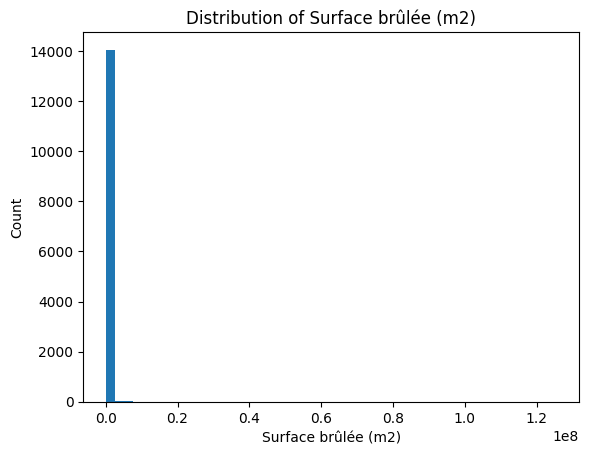

Median: 1000.0
Mean: 73934.38936924168


In [33]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(y, bins=50)
plt.title('Distribution of Surface brûlée (m2)')
plt.xlabel('Surface brûlée (m2)')
plt.ylabel('Count')
plt.show()

print(f"Median: {np.median(y)}")
print(f"Mean: {np.mean(y)}")


The mean (73,934) is way bigger than the median (1,000), which means your target variable Surface parcourue (m2) is heavily right-skewed. 

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Assuming X and y are your features and target

# Apply log transformation (add 1 to avoid log(0))
y_log = np.log1p(y)  

# Split the data
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Train linear regression on log-transformed target
model = LinearRegression()
model.fit(X_train, y_train_log)

# Predict on test set (log scale)
y_pred_log = model.predict(X_test)

# Evaluate model on log scale
mse_log = mean_squared_error(y_test_log, y_pred_log)
r2_log = r2_score(y_test_log, y_pred_log)

print(f"Test MSE (log scale): {mse_log:.2f}")
print(f"Test R² (log scale): {r2_log:.2f}")

# Back-transform predictions to original scale
y_pred = np.expm1(y_pred_log)  # inverse of log1p

# Evaluate model on original scale
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE (original scale): {mse:.2f}")
print(f"Test R² (original scale): {r2:.2f}")


Test MSE (log scale): 8.81
Test R² (log scale): 0.01
Test MSE (original scale): 442739458168.67
Test R² (original scale): -0.01


The log transform helped stabilize things, but the R² is still near zero, meaning the model barely explains the variance. Let's try a more advanced model.

# Random Forest 

In [35]:
from sklearn.ensemble import RandomForestRegressor

# Features and target
X = df.drop(columns=['Surface parcourue (m2)'])
y = df['Surface parcourue (m2)']

X['Nature_encoded'] = X['Nature'].astype('category').cat.codes
X = X.drop(columns=['Nature'])  # drop original categorical


# Log-transform the target to reduce skewness
y_log = np.log1p(y)  # log(1 + y)

# Select only numeric columns for the model (drop object/string columns)
X_numeric = X.select_dtypes(include=[np.number])

X_train, X_test, y_train_log, y_test_log = train_test_split(X_numeric, y_log, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train_log)

y_pred_log = rf.predict(X_test)

mse_log = mean_squared_error(y_test_log, y_pred_log)
r2_log = r2_score(y_test_log, y_pred_log)

y_test = np.expm1(y_test_log)
y_pred = np.expm1(y_pred_log)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE (log scale): {mse_log:.2f}")
print(f"Test R² (log scale): {r2_log:.2f}")
print(f"Test MSE (original scale): {mse:.2f}")
print(f"Test R² (original scale): {r2:.2f}")

Test MSE (log scale): 0.99
Test R² (log scale): 0.88
Test MSE (original scale): 22122724154.12
Test R² (original scale): 0.98


R² of 0.88 on log scale and 0.98 on original scale. The MSE dropped a lot compared to linear regression. Random Forest is performing way better than Linear Regression.

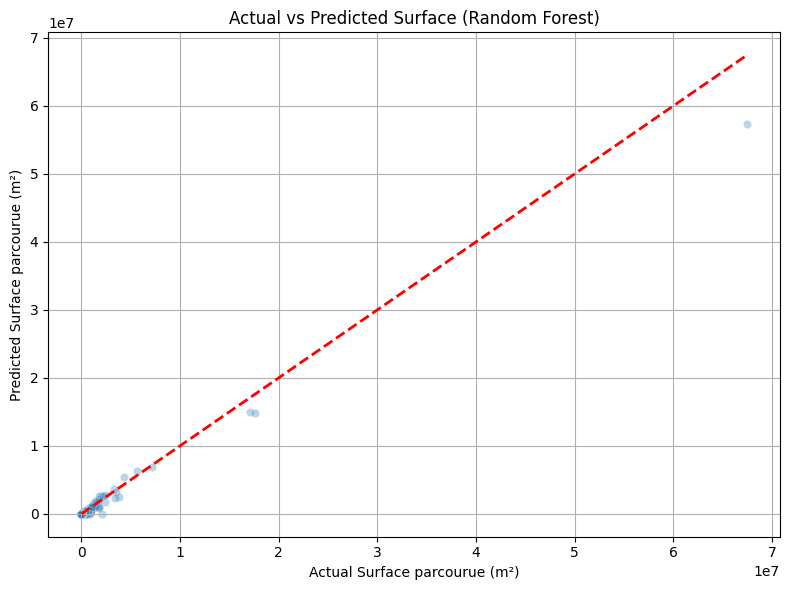

In [36]:
import seaborn as sns

# Scatter plot: Actual vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')
plt.xlabel("Actual Surface parcourue (m²)")
plt.ylabel("Predicted Surface parcourue (m²)")
plt.title("Actual vs Predicted Surface (Random Forest)")
plt.grid(True)
plt.tight_layout()
plt.show()


Checking for any problem in the dataset.

In [5]:
import os

# Load the dataset
df = pd.read_csv("df_nature_with_images.csv")

# Show basic info
print("Data Shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())

# Check for missing values in relevant columns
relevant_columns = [
    'Surface parcourue (m2)', 'latitude', 'longitude', 'temp', 'humidity',
    'pressure', 'wind_speed', 'wind_deg', 'rain_1h', 'Nature_encoded', 'image_path'
]

print("\n❓ Missing values in important columns:")
print(df[relevant_columns].isnull().sum())

# Check image path validity (first 5 only to avoid flooding)
print("\nChecking if image files exist for first 5 rows...")
for idx, path in enumerate(df['image_path'].head()):
    print(f"{idx}: {'Exists' if os.path.exists(path) else 'Missing'} - {path}")


Data Shape: (7820, 28)

Columns:
 ['Année', 'Numéro', 'Département', 'Code INSEE', 'Nom de la commune', 'Date de première alerte', 'Surface parcourue (m2)', 'Surface forêt (m2)', 'Surface maquis garrigues (m2)', 'Autres surfaces naturelles hors forêt (m2)', 'Surface autres terres boisées (m2)', 'Surfaces non boisées naturelles (m2)', 'Surfaces non boisées artificialisées (m2)', 'Surfaces non boisées (m2)', 'Précision des surfaces', 'Type de peuplement', 'Nature', 'latitude', 'longitude', 'temp', 'humidity', 'pressure', 'wind_speed', 'wind_deg', 'rain_1h', 'Nature_encoded', 'date_str', 'image_path']

❓ Missing values in important columns:
Surface parcourue (m2)    0
latitude                  0
longitude                 0
temp                      0
humidity                  0
pressure                  0
wind_speed                0
wind_deg                  0
rain_1h                   0
Nature_encoded            0
image_path                0
dtype: int64

Checking if image files exist fo

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# 🔧 Features to use from tabular data
features = [
    'latitude', 'longitude', 'temp', 'humidity', 'pressure', 
    'wind_speed', 'wind_deg', 'rain_1h', 'Nature_encoded'
]
target = 'Surface parcourue (m2)'

# X and y
X = df[features].values
y = df[target].values

# 🧪 Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 🔍 Normalize inputs
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Preprocessing done. Train shape:", X_train_scaled.shape)


✅ Preprocessing done. Train shape: (6256, 9)


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

# ⚙️ ANN model architecture
ann_model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # Output layer for regression
])

ann_model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mae']
)

# 📈 Train model
history = ann_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)


c:\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 686712225792.0000 - mae: 65534.9492 - val_loss: 281592528896.0000 - val_mae: 58987.9688
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 653261602816.0000 - mae: 63916.1094 - val_loss: 281589415936.0000 - val_mae: 58966.4609
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 944865214464.0000 - mae: 77962.7969 - val_loss: 281581027328.0000 - val_mae: 58918.5703
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 614838304768.0000 - mae: 61304.1406 - val_loss: 281563234304.0000 - val_mae: 58850.8750
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 427846631424.0000 - mae: 60341.6055 - val_loss: 281533841408.0000 - val_mae: 58779.6094
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1295568732160.0000 - mae: 89345.1484 - val_loss: 281498976256.0000 - val_mae: 58735.1953
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 555270340608.0000 - mae: 59628.0781 - val_loss: 281

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Test MAE: 104886.17
Test RMSE: 699967.66


c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


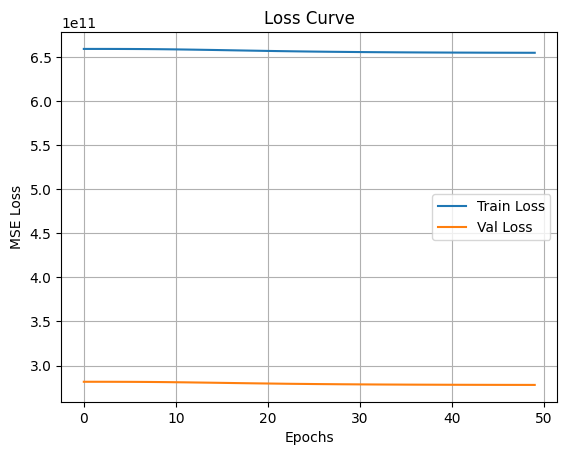

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Evaluate on test set
y_pred = ann_model.predict(X_test_scaled).flatten()
mae_test = mean_absolute_error(y_test, y_pred)
rmse_test = mean_squared_error(y_test, y_pred, squared=False)

print(f"Test MAE: {mae_test:.2f}")
print(f"Test RMSE: {rmse_test:.2f}")

# Plot learning curves
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()


In [9]:
import numpy as np

# Apply log1p to target (train + test)
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Redefine and re-train the model
from keras.models import Sequential
from keras.layers import Dense, Input

log_model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
])

log_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

log_history = log_model.fit(
    X_train_scaled, y_train_log,
    validation_data=(X_test_scaled, y_test_log),
    epochs=50, batch_size=32,
    verbose=1
)

# Evaluate
y_pred_log = log_model.predict(X_test_scaled).flatten()
y_pred_actual = np.expm1(y_pred_log)
mae_log = mean_absolute_error(y_test, y_pred_actual)
rmse_log = mean_squared_error(y_test, y_pred_actual, squared=False)

print(f"MAE (after log transform): {mae_log:.2f}")
print(f"RMSE (after log transform): {rmse_log:.2f}")


Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 31.3539 - mae: 4.6560 - val_loss: 10.0130 - val_mae: 2.5050
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10.0944 - mae: 2.5149 - val_loss: 8.9261 - val_mae: 2.3789
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.0344 - mae: 2.3845 - val_loss: 8.4996 - val_mae: 2.3289
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.2078 - mae: 2.2928 - val_loss: 8.2571 - val_mae: 2.3042
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.0737 - mae: 2.2919 - val_loss: 8.0376 - val_mae: 2.2615
Epoch 6/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.7237 - mae: 2.2433 - val_loss: 7.9290 - val_mae: 2.2553
Epoch 7/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.6470 - mae: 2.2472 - val_loss: 7.9022 - val_mae: 2.2529
Epoch 8/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.5168 - mae: 2.1997 - val_loss: 7.9719 - val_mae: 2.2588
Epoch 9/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step -

c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [13]:
# Define paths
base_dir = 'C:/Users/Antoine Dupont/Documents/!EFREI/OneDrive - Efrei/!Cours/Machine Learning/Project/Forest-Fire-Prediction/df_nature_with_images.csv'


# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Using 20% of the data for validation
)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(128, 128),  # Resize images to 128x128
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Set as training data
)

# Validation data generator
validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Set as validation data
)


NotADirectoryError: [WinError 267] Nom de répertoire non valide: 'C:/Users/Antoine Dupont/Documents/!EFREI/OneDrive - Efrei/!Cours/Machine Learning/Project/Forest-Fire-Prediction/df_nature_with_images.csv'